In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.nonparametric.smoothers_lowess import lowess
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
pip install hmmLearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 12.4 MB/s eta 0:00:00


In [3]:
from hmmlearn import hmm

In [4]:
from hmmlearn.hmm import GaussianHMM

In [6]:
df = pd.read_csv("/content/AAPL_stock_data.csv")
print(df)

      Unnamed: 0       Price       Close  log_price     Range  Volume_Scaled
0              0  2020-12-03  120.085472   4.788204  1.533546       0.175510
1              1  2020-12-04  119.411484   4.782575  1.308890       0.152297
2              2  2020-12-07  120.876663   4.794771  2.266132       0.429712
3              3  2020-12-08  121.492012   4.799849  1.846123       0.282447
4              4  2020-12-09  118.952400   4.778723  4.835063       1.361167
...          ...         ...         ...        ...       ...            ...
1058        1058  2025-02-21  245.550003   5.503501  3.470001      -0.670373
1059        1059  2025-02-24  247.100006   5.509793  4.440002      -0.731787
1060        1060  2025-02-25  247.039993   5.509550  5.089996      -0.840536
1061        1061  2025-02-26  240.360001   5.482138  5.849991      -0.958036
1062        1062  2025-02-27  237.300003   5.469325  5.400009      -1.065699

[1063 rows x 6 columns]


In [7]:
df.drop("Unnamed: 0" , axis = 1 , inplace = True)

In [8]:
df.rename(columns = {'Price' : 'Date'} , inplace = True)
df

,Date,Close,log_price,Range,Volume_Scaled
0,2020-12-03,120.085472,4.788204,1.533546,0.175510
1,2020-12-04,119.411484,4.782575,1.308890,0.152297
2,2020-12-07,120.876663,4.794771,2.266132,0.429712
3,2020-12-08,121.492012,4.799849,1.846123,0.282447
4,2020-12-09,118.952400,4.778723,4.835063,1.361167
...,...,...,...,...,...
1058,2025-02-21,245.550003,5.503501,3.470001,-0.670373
1059,2025-02-24,247.100006,5.509793,4.440002,-0.731787
1060,2025-02-25,247.039993,5.509550,5.089996,-0.840536
1061,2025-02-26,240.360001,5.482138,5.849991,-0.958036


In [9]:
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

In [10]:
loess_smoothed = lowess(
    endog=train_df['log_price'],
    exog=train_df.index.values.astype(float),
    frac=0.02,
    return_sorted=False
)

In [11]:
train_df['LOESS_trend'] = loess_smoothed
train_df['LOESS_residual'] = train_df['log_price'] - train_df['LOESS_trend']

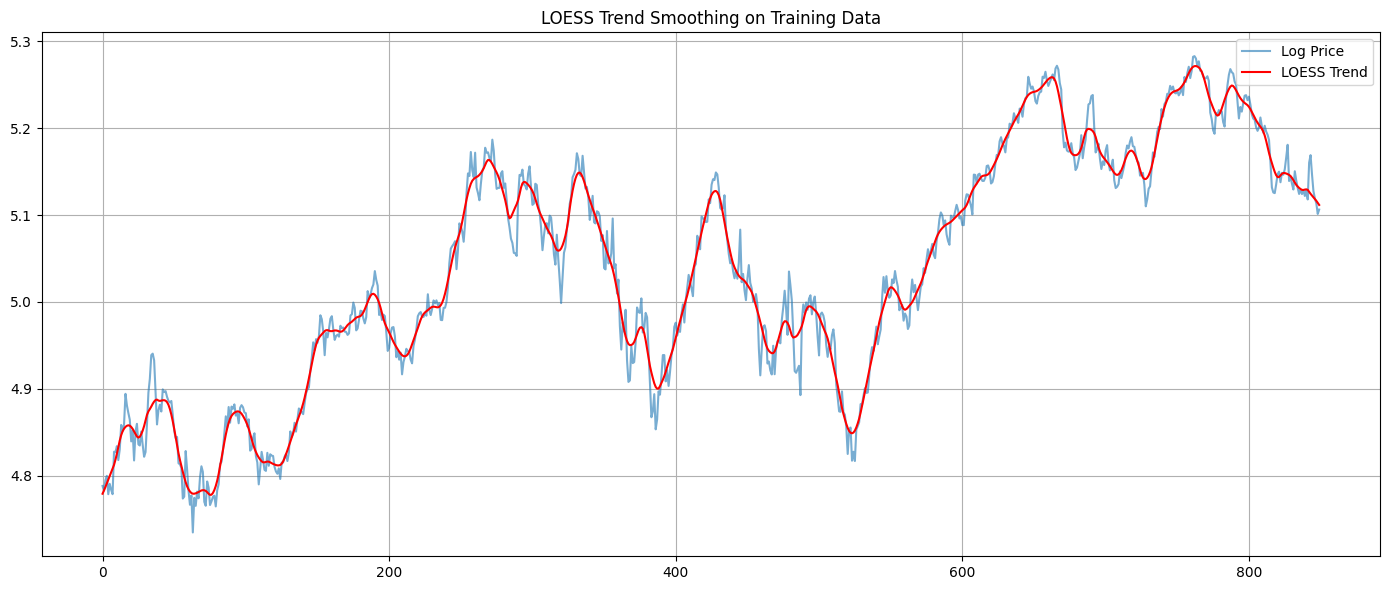

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(train_df.index, train_df['log_price'], label='Log Price', alpha=0.6)
plt.plot(train_df.index, train_df['LOESS_trend'], label='LOESS Trend', color='red')
plt.title('LOESS Trend Smoothing on Training Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
X_hmm = train_df['LOESS_residual'].dropna().values.reshape(-1, 1)
X_hmm

array([[ 8.93470044e-03],
       [-4.92514466e-04],
       [ 7.74436000e-03],
       [ 8.70549832e-03],
       [-1.66679903e-02],
       [-9.06886294e-03],
       [-2.01333004e-02],
       [-2.94759414e-02],
       [ 1.51896390e-02],
       [ 8.68207427e-03],
       [ 8.62415747e-03],
       [-1.50404955e-02],
       [-1.01014501e-02],
       [ 1.17684631e-02],
       [ 2.80584183e-04],
       [ 4.92815201e-03],
       [ 3.79898746e-02],
       [ 2.33420130e-02],
       [ 1.42548605e-02],
       [ 6.94670016e-03],
       [-1.66428880e-02],
       [-2.07946618e-03],
       [-3.33244441e-02],
       [ 3.39240046e-03],
       [ 1.45840476e-02],
       [-7.73960171e-03],
       [-1.00713048e-02],
       [ 3.14402563e-03],
       [-1.62359781e-02],
       [-3.53422395e-02],
       [-3.65051490e-02],
       [-1.04700097e-02],
       [ 2.15149893e-02],
       [ 3.48090390e-02],
       [ 5.92187472e-02],
       [ 5.77302935e-02],
       [ 4.74301041e-02],
       [ 1.00232286e-02],
       [-2.8

In [14]:
hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, random_state=42)
hmm_model.fit(X_hmm)

GaussianHMM(covariance_type='full', n_components=3, n_iter=1000,
            random_state=42)

In [15]:
hidden_states = hmm_model.predict(X_hmm)

In [16]:
train_df = train_df.loc[train_df['LOESS_residual'].notna()].copy()
train_df['HMM_State'] = hidden_states

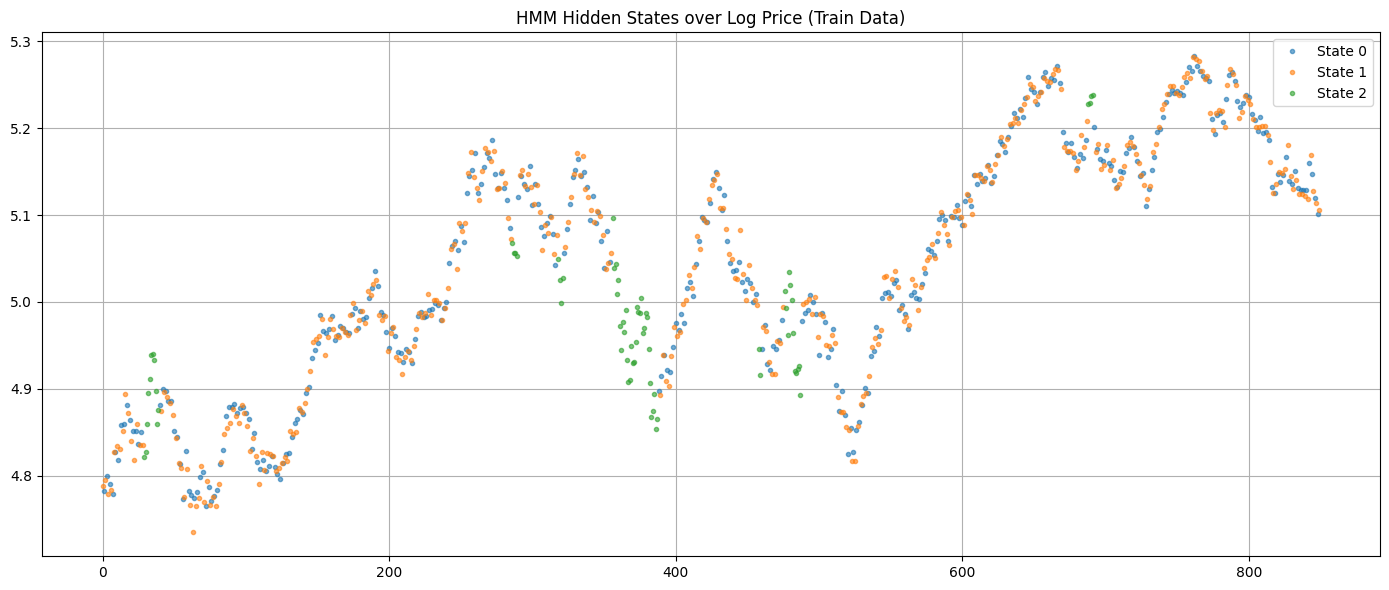

In [17]:
plt.figure(figsize=(14, 6))
for state in np.unique(hidden_states):
    idx = train_df['HMM_State'] == state
    plt.plot(train_df.index[idx], train_df['log_price'][idx], '.', label=f'State {state}', alpha=0.6)

plt.title('HMM Hidden States over Log Price (Train Data)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Step 1: Drop NaNs and lag features
features = ['LOESS_residual', 'LOESS_trend', 'Volume_Scaled', 'Range']
train_df = train_df.dropna()

# Step 2: One-hot encode HMM states
hmm_encoded = pd.get_dummies(train_df['HMM_State'], prefix='State')

# Step 3: Combine all features
X = pd.concat([train_df[features], hmm_encoded], axis=1)

# Step 4: Create target — next day log price
y = train_df['log_price'].shift(-1).loc[X.index]

# Drop last row due to shift(-1)
X = X.iloc[:-1]
y = y.iloc[:-1]

# Step 5: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [19]:
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

# Define sequence window size (e.g., past 20 days)
window_size = 20

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y.values, window_size)

# Confirm shape
print(f'X shape: {X_seq.shape}, y shape: {y_seq.shape}')

X shape: (829, 20, 7), y shape: (829,)


In [20]:
# Define the model
model = Sequential()
model.add(LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for regression

# Compile
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Train
history = model.fit(
    X_seq, y_seq,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False  # Important for time series
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 23.3977 - val_loss: 27.9519
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.2213 - val_loss: 0.1155
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8118 - val_loss: 0.0345
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2944 - val_loss: 0.0174
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3375 - val_loss: 0.0235
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2904 - val_loss: 0.0082
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3184 - val_loss: 0.0178
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3281 - val_loss: 0.0079
Epoch 9/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3271 - val_loss: 0.0019
Epoch 10/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2845 - val_loss: 0.0055
Epoch 11/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2966 - val_loss: 9.9961e-04
Epoch 12/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


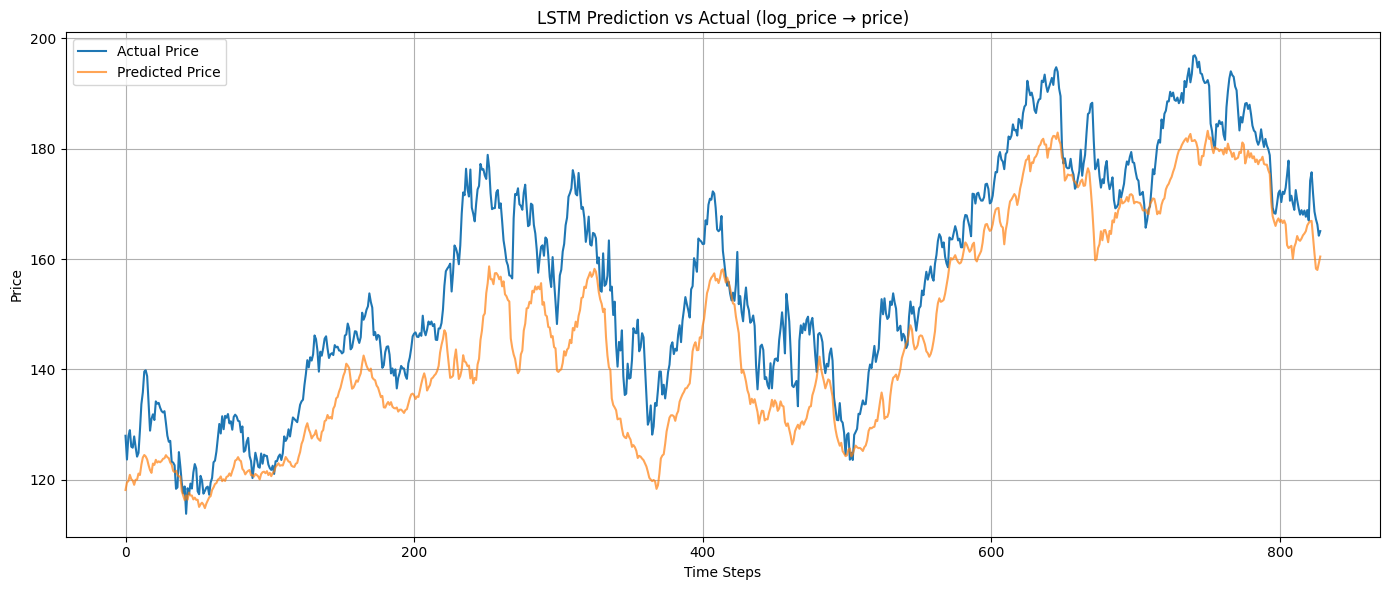

In [21]:
# Predict on train data (or validation/test)
y_pred = model.predict(X_seq)

# Optional: convert log price back to price
y_true_price = np.exp(y_seq)
y_pred_price = np.exp(y_pred.flatten())

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(y_true_price, label='Actual Price')
plt.plot(y_pred_price, label='Predicted Price', alpha=0.7)
plt.title('LSTM Prediction vs Actual (log_price → price)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()